# 3장 평가(Evaluation)

### 분류(Classification) 성능 평가 지표
* 정확도(Accuracy) → 이진분류에선 잘 쓰이지 않음
* 오차행렬(Confusion Matrix)
* 정밀도 (Prescision)
* 재현율 (Recall)
* F1 스코어
* ROC AUC → 이진분류일때 많이 사용함

## 3-1 Accuracy(정확도)

정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

* 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표. 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에
정확도 수치 하나만 가지고 성능을 평가하지 않음

* 특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.


예: 신용카드 데이터 1만건 중 1건만 사기일 경우. 사기 0건으로 해버리면 정확도 99퍼에 수렴..


다른 예:
1. 타이타닉 생존자 예측에서 여성은 모두 생존으로 판별
If Sex= '여성' 

생존

2. MNIST multi classification에서 binary classification으로 변경

MNIST는 0에서부터 9로 레이블을 매기는데.
이걸 살짝 바꿔서 0-9까지 숫자중에 7이냐 아니냐를 하게되면 1/10인 7만 TRUE, 나머진 FALSE가 된다

In [12]:
import numpy as np
from sklearn.base import BaseEstimator


#먼저 더미 클래스파이어를 만들 것임. 사이킷런에서 쓸 수 있는것. 사이킷런은 기본적으로 
#Estimator에서 분류일 경우 classfier 와 회귀일 경우 regressor를 만든다. 


# 생성자 안에 BaseEstimator 부모 클래스를 넣어서 상속을 받는다.
# 그 안에 classfier에 가장 기반이 되는 메소드 fit 과 predict를 직접 만든다.

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메소드는 아무것도 학습하지 않음. 
    def fit(self, X , y=None):
        pass
    
    # predict( ) 메소드는 단순히 Sex feature가 1(남자) 이면 0(사망) , 그렇지 않으면 1 로 예측함. 
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1 )) #뒤에 1은 2차원으로 명확하게 하겠다는건데 안써도 되긴 한다.
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
        
        return pred


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행. 
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


위의 결과를 보면 성별이 남자인거로만해도 정확도가 78퍼가 나와버림. 특별한 알고리즘이 없이 남성을 사망, 여성을 생존으로만 해도 이렇게 나와버림.

이제부턴 MNIST

In [15]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환(뭐가 들어오더라도)
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


~~~
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)
~~~
8x8을 풀어서 64. 1797의 row가 있는 것.

타겟은 0이면 0, 1이면 1... 레이블.1797 1차원 쉐이프.

In [16]:
digits.target == 7

array([False, False, False, ..., False, False, False])

~~~
digits.target == 7
~~~
이런식으로하면 불리안 값으로 어레이가 생긴다.

In [17]:
# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환. 
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [18]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


정리: 정확도는 이진분류일 경우 이렇게 양날의 검이 되므로 잘 사용하지 않는다.
밑에서부터 이진분류일 때 자주 사용하는 것

## Confusion Matrix ( 오차행렬 )

오차행렬은 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

|실제 클래스(Acutual Class) |예측클래스|(predicted Class)|
|:-----:|:---------:|:----------:|
|       |Negative(0)|Positive (1)|
|Negative(0)| TN(True Negative)| FP (Flase Positive)|
|Positive(1)|FN(False Negative)| TP (True Positive)|

#### 의미

**TN**은 예측을 네거티브로 했는데 True, 맞았다. **FP**는 실제로는 Negative인데 Positive로 예측했다. 틀렸다.


**PN**은 예측을 네거티브로 했는데 False, 틀렸다. **TP**는 실제로 positive 인데 예측도 positive로 했다. 맞았다.  

In [19]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
confusion_matrix(y_test , fakepred)

array([[405,   0],
       [ 45,   0]])

405 는 TN, 45는 FN.

- TP는 0. Positive로 예측이 한 건도 성공하지 않음.
- 이와 더불어 FP가 0이므로 Positive로 예측 자체를 수행하지 않음을 알 수 있음.

TN이 무려 405개가 나와서 정확도가 90퍼센트나 나와버렸다. 그래서 이런 불균형한 데이터 셋에선 정확도를 쓰면 안됨

**정확도 = 예측 결과와 실제 값이 동일한 건수/ 전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)**

## 정밀도(Precision) 과 재현율(Recall)
이진분류에서 많이 쓰인다.


|실제 클래스(Acutual Class) |예측클래스|(predicted Class)|
|:-----:|:---------:|:----------:|
|       |Negative(0)|Positive (1)|
|Negative(0)| TN(True Negative)| FP (Flase Positive)|
|       |405개      |       0     |
|Positive(1)|FN(False Negative)| TP (True Positive)|
|       |45개      |      0      |

오차행렬에서 쉽게 계산할 수 있다.

   * **정밀도 = TP / (FP+TP)**
   * **재현율 = TP / (FN+TP)**
정밀도는 FP가 낮아져야 높아진다.
재현율은 FN이 낮아져야 된다.

왜냐? P로 예측을 한게 틀리는 값이 낮아져야 정밀도가 높아지고
FN이 뜻하는건 예측을 N으로 한건데 틀렸다. 즉 실제 값이 Positive라는 것

* 정밀도는 **예측을 Positive로 한 대상** 중에 예측과 실제 값이 positive로 일치한 데이터의 비율
* 재현율은 **실제 값이 positive 인 대상** 중에 예측과 실제 값이 positive로 일치한 데이터의 비율

### 사이킷런의 정밀도, 재현율

* 정밀도는 precision_score( ), 재현율은 recall_score( ) 제공

**MyFakeClassifier의 예측 결과로 정밀도와 재현율 측정**

In [20]:
from sklearn.metrics import accuracy_score, precision_score , recall_score

print("정밀도:", precision_score(y_test, fakepred))
print("재현율:", recall_score(y_test, fakepred))

정밀도: 0.0
재현율: 0.0


/Users/sang-woolee/Library/Python/3.6/lib/python/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


위 결과 두개다 0 이 나오는 이유는  
둘다 TP가 0이다. 그래서 분자가 0이므로 정밀도, 재현율 다 0이 나온다.  
여기서 MyFakeClassifier가 못 쓰는 모델이구나 라는게 들통이 나는 것

**오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성**

In [21]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

# 새로운 함수를 하나 만들어서, 실제 Y 값과 예측 Y 값을 넣을것. 거기서 오차율, 정확도, 정밀도, 재현율 구하는 함수를 만듦.
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [22]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression(max_iter = 1000)#default max_iter =100인데 더 필요해서 수정함.

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869






### Precision/Recall Trade-off 정밀도/ 재현율 트레이드 오프

#### 업무에 따른 재현율과 정밀도의 상대적 중요도

* 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우: 암 진단, 금융사기 판별. **암인데, 암이 아닌데요? 라던가. 사기인데 사기 아닌데요? 라던가**
* 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우: 스팸 메일 **정상 메일인데 스팸 메일이라고 판단해서 중요한 메일이 스팸에 되어버림.업무적으로 문제가 크게 생길 수 있다**

✰ 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야하는 매우 적은 수의 결과값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0 값을 일반적으로 부여합니다.

- 분류하려는 **업무 특성상 정밀도 또는 재현율이 특별히 강조**돼야 할 경우 **분류의 결정 임계값(threshold)를 조정해 정밀도 또는 재현율의 수치를 높일 수 있습니다.**
- 하지만 정밀도와 재현율은 **상호 보완적**인 평가 지표이기 때문에 어느 **한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.** 이를 **정밀도/ 재현율의 트레이드 오프(Trade-off)라고 부른다.**

* 사이킷런 Estimator 객체의 predict_proba ( )메소드는 분류 결정 예측 확률을 반환한다.
* 이를 이용하면 임의로 분류 결정 임계값을 조정하면서 예측 확률을 변경할 수 있다.

**predict_proba( ) 메소드 확인**

predict는 예측 값을 반환. predict_proba( )는 이진분류일 때, 0일때 확률이 얼마고 1일때 확률이 얼마인지를 반환한다.  
코드를 보면 더 이해하기 쉬움

In [26]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)

print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)#pred로 반환된 predict 결과는 1차원 이기 때문에 2차원으로 reshape
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46230275 0.53769725]
 [0.87875153 0.12124847]
 [0.87718009 0.12281991]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46230275 0.53769725 1.        ]
 [0.87875153 0.12124847 0.        ]
 [0.87718009 0.12281991 0.        ]]


**Binarizer 활용**
Binarizer는 preprocessing 패키지안에 있는건데 역시 전처리를 위한 패키지임.

In [27]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


**분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환**  
(predict_proba( ) 메소드와 binarizer를 사용하여 predict 메소드를 흉내를 내보는 연습)

In [28]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)#Binarizer에 들어가기 위해 2차원으로 만듦

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)


'''
앞의 결과는 

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

앞의 결과랑 똑같이 나온다.
'''

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


**분류 결정 임계값 0.4 기반에서 Binarizer를 이용하여 예측값 변환**  
(코드는 똑같이. 해보면 정밀도는 낮아지고 재현율은 높아졌다)

In [29]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


**여러개의 분류 결정 임곗값을 변경하면서  Binarizer를 이용하여 예측값 변환**

In [30]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


**precision_recall_curve( ) 를 이용하여 임곗값에 따른 정밀도-재현율 값 추출**

In [35]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
반환된 precisions 배열의 Shape: (144,)
반환된 recalls 배열의 Shape: (144,)
thresholds 5 sample: [0.10385437 0.1038566  0.10388157 0.10796928 0.10882457]
precisions 5 sample: [0.38853503 0.38461538 0.38709677 0.38961039 0.38562092]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.96721311]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


**임곗값의 변경에 따른 정밀도-재현율 변화 곡선을 그림**

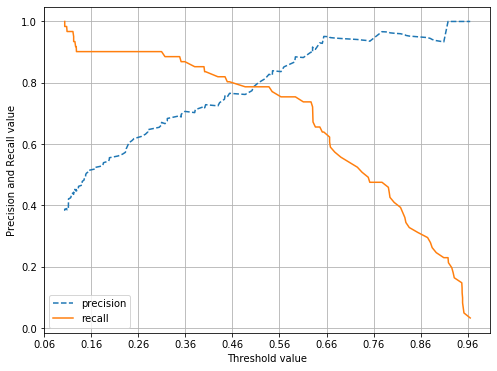

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )


### 정밀도와 재현율의 맹점

#### 정밀도를 100% 로 만드는 법→ 아예 확실한 것만 P로 예측, FP를 0으로 만듦


* 확실한 기준이 되는 경우만 Positive로 예측, 나머지는 모두 Negative로 예측. 정밀도 = TP / (TP + FP).  
전체 환자 1000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 하면, 이 한명만 Positive로 예측, 나머지를 모두 Negative로 예측하더라도
FP는 0, TP는 1이 되므로 정밀도는 1/(1+0)으로 100%가 된다. 왜냐? FP가 틀릴래야 틀릴 수 가 없으니까.

#### 재현율을 100%로 만드는 법→ 전부다 P로 예측, FN을 0으로 만듦


* 모든 환자를 Positive로 예측하면 됨. 재현율 = TP / (TP + FN) 이므로 전체 환자 1000명을 다 Positive 로 예측.
이 중 실제 양성인 사람이 30명 정도라도 TN이 수치에 포하되지 않고 FN은 아예 0이므로 30/(30+0)으로 100%가 됨. 

### 3.4 F1 Score

![F1 Score](img/F1Score.png)

In [37]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))


F1 스코어: 0.7805


In [38]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


## 3-5 ROC Curve와 AUC

**ROC 곡선(Receiver Operation Characteristic Curve)** 와 이에 기반한 **AUC 스코어**는 이진 분류의 예측 성능 측정에서 중요하게 사용 되는 지표.  
일반적으로 의학 분야에서 많이 사용되나, 머신러닝 이진분류 모델 예측 성능 판단에 중요한 평가 지표.

![ROC and AUC](img/ROC.png)

![FPR_TPR](img/FPR_TPR.png)

In [44]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 5)
print('thr_index 어떻게 생겼는지:', thr_index)
print('thresholds:',thresholds)
print('thresholds.shape:', thresholds.shape)
print('thresholds.shape[0]:', thresholds.shape[0])
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))


thr_index 어떻게 생겼는지: [ 0  5 10 15 20 25 30 35 40 45 50]
thresholds: [1.96507494 0.96507494 0.91799638 0.90896795 0.77770862 0.75177783
 0.65418657 0.6509755  0.64568999 0.636257   0.63079001 0.6303004
 0.63028422 0.6269439  0.61068144 0.59378877 0.5631572  0.54529726
 0.54473419 0.53769725 0.48716816 0.45391728 0.44915722 0.44432865
 0.42922769 0.40322709 0.40104507 0.39963586 0.37992339 0.35902539
 0.35104269 0.34799325 0.31678853 0.30956036 0.2402939  0.23464197
 0.14829528 0.14829498 0.12878842 0.12830329 0.12696502 0.12546605
 0.12282585 0.12282095 0.12276573 0.12124847 0.11195926 0.11192497
 0.11155695 0.11151138 0.10882457 0.10796928 0.1038566  0.10385437
 0.0116047 ]
thresholds.shape: (55,)
thresholds.shape[0]: 55
샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임곗값:  [1.97 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
샘플 임곗값별 TPR:  [0.    0.475 0.689 0.754 0.787 0.836 0

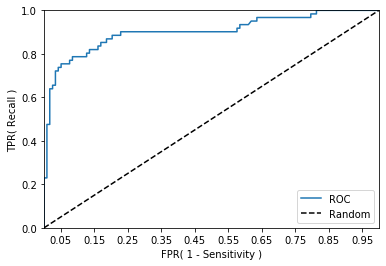

In [40]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )


![sk_ROC_AUC](img/sk_ROC_AUC.png)

In [45]:
from sklearn.metrics import roc_auc_score

### 아래는 roc_auc_score()의 인자를 잘못 입력한 것으로, 책에서 수정이 필요한 부분입니다. 
### 책에서는 roc_auc_score(y_test, pred)로 예측 타겟값을 입력하였으나 
### roc_auc_score(y_test, y_score)로 y_score는 predict_proba()로 호출된 예측 확률 ndarray중 Positive 열에 해당하는 ndarray입니다. 

#pred = lr_clf.predict(X_test)
#roc_score = roc_auc_score(y_test, pred)

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))


ROC AUC 값: 0.9025


In [46]:

#인자로 pred_proba를 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
